<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="300" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:**<span style="color:purple"> <font size="4.5"> **Ana María Aguilera Gómez, <span style="color:blue"> Esteban Márquez Delgado**

**Fecha:** *26 de noviembre del 2021*
   
**Expedientes:** 
<span style="color:purple"> <font size="4.5"> **720567,
<span style="color:blue"> <font size="4.5"> 700637**
    
**Profesor:** Oscar David Jaramillo Zuluaga.
**Link Github:** https://github.com/EMarquez7/Tarea9_AMAguilera_EMarquez

# Tarea 9

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:

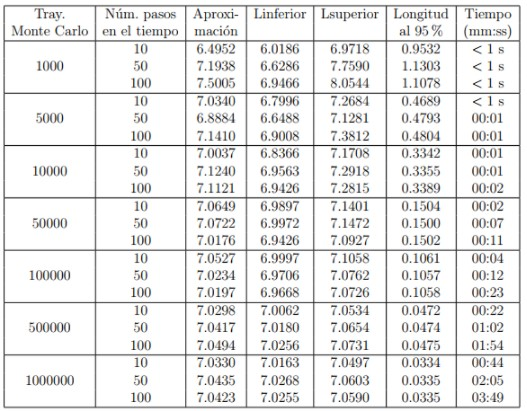

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

>**Nota:** Para generar índices de manera como se especifica en la tabla referirse a:
> - https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html
> - https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html
> - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html

#### Código de solución `ESTUDIANTE 1: Ana María Aguilera Gómez`

#### Código de solución `ESTUDIANTE 2: Esteban Márquez Delgado`

Para un call asiático de promedio aritmético y con precio de ejercicios fijo, dado por:
$$\max \{A(T)-K,0\} = (A(T)-K)_+$$

con $A(x)={1\over x} \int_0^x S_u du$

Se puede ver que el valor en el tiempo t de la opción call asiática está dado por:

$$ V_t(K) = e^{-r(T-t)}E^*[(A(T)-K)_+]$$

Para el caso de interés, *Valución de la opción*, donde $t_0=0$ y $t=0$, se tiene:

$$\textbf{Valor call asiático}\longrightarrow V_0(K)=e^{-rT}E\Bigg[ \Big({1\over T} \int_0^T S_u du -K\Big)_+\Bigg]$$ 

## Usando Monte Carlo

Para usar este método es necesario que se calcule el promedio $S_u$ en el intervalo $[0,T]$. Para esto se debe **aproximar el valor de la integral** por los siguiente dos métodos.

Para los dos esquemas se dividirá el intervalo $[0,T]$ en N subintervalos de igual longitud, $h={T\over N}$, esto determina los tiempos $t_0,t_1,\cdots,t_{N-1},t_N $, en donde $t_i=ih$ para $i=0,1,\cdots,N$

### 1. Sumas de Riemann

$$\int_0^T S_u du \approx h \sum_{i=0}^{n-1} S_{t_i}$$

De este modo, si con el método de Monte Carlo se generan $M$ trayectorias, entonces
la aproximación de el valor del call asiático estaría dada por:

$$\hat V_0^{(1)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({1\over N} \sum_{i=0}^{N-1} S_{t_i}-K \Bigg)_+$$


In [24]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [25]:
#Black-Scholes
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2 #r-(sigma**2)/2
    DeltaT = 1/NbStep #DeltaT = Años/Pasos
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1) #v.a.n de tray. y pasos 
    #DeltaW se mult. por sq(DeltaT), proceso de Wiener escalado 
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    #Concatenado del: (log de S0(inicial)*vector de unos(por ser c)) con los incrementos por filas (axis=0) 
    
    #St= np.exp(concat.cumsum(axis=0))= Suma acumulada de los resultados por fila (exp. cancela log)
    
    #Para simular los precios iniciando desde S0..
    LogSt = np.cumsum(concat,axis=1)
    St = np.exp(LogSt) # Se obtienen los precios simulados para los NbStep fijados
    t = np.arange(0,NbStep)  # Vector con la cantidad de días simulados

    return St.T,t


#def calc_daily_ret(closes): #Función de los rendimientos logarítmicos diarios
    #return np.log(closes/closes.shift(1)).iloc[1:]

In [26]:
#Cálculo de prima con método de Sumas de Riemann.
def Sumas_de_Riemann(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     contrato='call o put', flag=None):
    inicio = time.time() #Inicia tiempo
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep) # Resolución de la ecuación de BS p./ obtener St (p)
    P = pd.DataFrame(St,index=t) # En df..
    Average_t = P.expanding().mean() #Se obtienen los precios suavizados (expanding) promedio
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t) #Vector x k(c)
    if contrato == 'call':  
        # Call de la opción según la fórmula de Sumas de Riemann
        call = pd.DataFrame({'Prima_EA': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, np.ones([NbStep,NbTraj])).mean(axis=1)}, index=t)
        
    else: 
        # Se calcula el put **
        call = pd.DataFrame({'Prima_EA': np.exp(-r*T) \
                     *np.fmax(strike - Average_t, np.ones([NbStep,NbTraj])).mean(axis=1)}, index=t)
    
    confianza = 0.95
    sigma_est = call.sem().Prima_EA #sem = error std. de la media
    mean_est = np.round(call.iloc[-1].Prima_EA,4) #media estimada
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est) #intervalos al 95%
    i1 = np.round(i1,4) 
    long = np.round(i1[1]-i1[0],4) #L.S- L.I
    fin= time.time() #Finaliza tiempo
    tiempo =int(fin-inicio) #Contabilizar tiempo
    tiempo_format = '{0:02.0f}:{1:02.0f}'.format(*divmod(tiempo, 60)) #Formato mm:ss
    tiempo_1s = lambda t: '<1s' if t<='00:01' else t #Expresion <1s de serlo

    return np.array([mean_est,i1[0],i1[1],long,tiempo_1s(tiempo_format)]) #Columnas de Riemann 
                    

#### Datos: 

In [27]:
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000] #NBtraj: Trayectorias en las columnas
NbStep = [10, 50, 100] #Nbstep: Pasos o días en filas
T=1 #año
S0 = 100 #Precio inicial
K = 100 #Precio de ejercicio del call euroasiatico
r = 0.10 #Tasa libre de riesgo 
sigma = 0.2 #Desv. std de los rendimientos

#### Call

In [6]:
arr_df = list(map(lambda nb_traj: list(map(lambda nb_step: Sumas_de_Riemann(K, r, S0, nb_traj, nb_step, 
                                                                    sigma, T, 'call'),
                                 NbStep)),
         NbTraj))

Aprox=[arr_df[nstep][ntraj][0] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
LI=[arr_df[nstep][ntraj][1] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
LS=[arr_df[nstep][ntraj][2] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
L=[arr_df[nstep][ntraj][3] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
t=[arr_df[nstep][ntraj][4] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]

In [7]:
arrays = [
    np.array([1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,\
              100000,100000,100000,500000,500000,500000,1000000,1000000,1000000]),
    np.array([10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]),
]

df = pd.DataFrame({'Aprox.': Aprox ,
                   'Lim.Inf':LI,
                   'Lim.Sup':LS,
                   'Longitud al 95%':L,
                   'Tiempo m:s':t}, index=arrays)

df.index.set_names(['Tray. de Sumas de Riemann', 'N° Pasos'],inplace=True)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
df

Aprox. Lim.Inf Lim.Sup Longitud al 95%  \
Tray. de Sumas de Riemann N° Pasos                                           
1000                      10        7.0473  5.7888  8.3058           2.517   
                          50        7.3145  6.8055  7.8235           1.018   
                          100       7.2309  6.8843  7.5775          0.6932   
5000                      10        6.6819  5.5045  7.8593          2.3548   
                          50        7.2445  6.7501  7.7389          0.9888   
                          100       7.4208  7.0672  7.7744          0.7072   
10000                     10        6.7153  5.5328  7.8978           2.365   
                          50        7.2297  6.7322  7.7272           0.995   
                          100       7.1401  6.8033  7.4769          0.6736   
50000                     10         6.711  5.5282  7.8938          2.3656   
                          50        7.2237  6.7287  7.7187            0.99   
                          100       7.3109  6.9627  7.6591          0.6964   
100000                    10        6.7548  5.5624  7.9472          2.3848   
                          50        7.2732  6.7738  7.7726          0.9988   
                          100       7.3031  6.9548  7.6514          0.6966   
500000                    10         6.782  5.5846  7.9794          2.3948   
                          50        7.2306  6.7345  7.7267          0.9922   
                          100       7.3443  6.9942  7.6944          0.7002   
1000000                   10        6.7733  5.5776   7.969          2.3914   
                          50        7.2581  6.7593  7.7569          0.9976   
                          100       7.3276  6.9783  7.6769          0.6986   

                                   Tiempo m:s  
Tray. de Sumas de Riemann N° Pasos             
1000                      10              <1s  
                          50              <1s  
                          100             <1s  
5000                      10              <1s  
                          50              <1s  
                          100             <1s  
10000                     10              <1s  
                          50              <1s  
                          100             <1s  
50000                     10              <1s  
                          50              <1s  
                          100             <1s  
100000                    10            00:02  
                          50            00:02  
                          100           00:03  
500000                    10            00:10  
                          50            00:12  
                          100           00:15  
1000000                   10            00:20  
                          50            00:24  
                          100           00:30

Debido a que la región llenada con rectángulos no tiene exactamente la misma forma que el área bajo la curva que se mide, las sumas de Riemann demuestran no ser un método de aproximación acertado o eficiente debido al poder de cómputo que requiere calcular un gran número de pasos y trayectorias.

#### Put

In [8]:
arr_df = list(map(lambda nb_traj: list(map(lambda nb_step: Sumas_de_Riemann(K, r, S0, nb_traj, nb_step, 
                                                                    sigma, T, 'put'),
                                 NbStep)),
         NbTraj))

Aprox=[arr_df[nstep][ntraj][0] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
LI=[arr_df[nstep][ntraj][1] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
LS=[arr_df[nstep][ntraj][2] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
L=[arr_df[nstep][ntraj][3] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
t=[arr_df[nstep][ntraj][4] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]

In [9]:
arrays = [
    np.array([1000,1000,1000,5000,5000,5000,10000,10000,10000,50000,50000,50000,\
              100000,100000,100000,500000,500000,500000,1000000,1000000,1000000]),
    np.array([10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100]),
]

df = pd.DataFrame({'Aprox.': Aprox ,
                   'Lim.Inf':LI,
                   'Lim.Sup':LS,
                   'Longitud al 95%':L,
                   'Tiempo m:s':t}, index=arrays)

df.index.set_names(['Tray. de Sumas de Riemann', 'N° Pasos'],inplace=True)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
df

Aprox. Lim.Inf Lim.Sup Longitud al 95%  \
Tray. de Sumas de Riemann N° Pasos                                           
1000                      10        3.0488  2.6209  3.4767          0.8558   
                          50        2.8361     2.7  2.9722          0.2722   
                          100       2.8028  2.7073  2.8983           0.191   
5000                      10        2.8223  2.4382  3.2064          0.7682   
                          50        2.9025  2.7593  3.0457          0.2864   
                          100       2.8932  2.7969  2.9895          0.1926   
10000                     10        2.8476  2.4597  3.2355          0.7758   
                          50        2.9108  2.7684  3.0532          0.2848   
                          100       2.8718  2.7762  2.9674          0.1912   
50000                     10        2.8065  2.4278  3.1852          0.7574   
                          50        2.9128   2.769  3.0566          0.2876   
                          100       2.9695  2.8687  3.0703          0.2016   
100000                    10        2.8144  2.4337  3.1951          0.7614   
                          50        2.9453  2.7989  3.0917          0.2928   
                          100       2.9346  2.8356  3.0336           0.198   
500000                    10        2.8111  2.4319  3.1903          0.7584   
                          50        2.9371  2.7915  3.0827          0.2912   
                          100       2.9433  2.8439  3.0427          0.1988   
1000000                   10        2.8152  2.4348  3.1956          0.7608   
                          50        2.9339  2.7885  3.0793          0.2908   
                          100        2.938  2.8386  3.0374          0.1988   

                                   Tiempo m:s  
Tray. de Sumas de Riemann N° Pasos             
1000                      10              <1s  
                          50              <1s  
                          100             <1s  
5000                      10              <1s  
                          50              <1s  
                          100             <1s  
10000                     10              <1s  
                          50              <1s  
                          100             <1s  
50000                     10              <1s  
                          50              <1s  
                          100             <1s  
100000                    10            00:02  
                          50            00:02  
                          100           00:03  
500000                    10            00:10  
                          50            00:12  
                          100          130:54  
1000000                   10            00:22  
                          50            00:25  
                          100           00:30

Si bien la media de las aproximaciones parecieran no efectuar exitósamente una convergencia, esta sucede y puede comprobarse mediante la acotación de la longitud entre los intervalos cada vez menor. Si bien, claro está que esto no significa que las Sumas de Riemann sean un método numérico eficiente para efectuar dicha aproximación pues con 1000 pasos, hechos para verificar su convergencia, se retorna el sig. mensaje tras 14min:  

- *MemoryError: Unable to allocate 7.45 GiB for an array with shape (1000, 1000000) and data type float64*

### 2. Esquema del trapecio

$$\int_0^T S_u du = \sum_{i=0}^{N-1}\int_{t_i}^{t_{i+1}}S_udu ;$$
$$\approx \sum_{i=0}^{N-1} {h\over2} [S_{t_i}+S_{t_{i+1}}] ;$$
$${h\over2}\sum_{i=0}^{N-1}{S_{t_i}+S_{t_i}e^{\bigl(r-{1\over 2}\sigma^2\bigr)h+\bigl(W_{t+1}-W_{t_i}\bigr)\sigma}}$$

Desarrollando la exponencial en serie de taylor y suponiendo que $h$ es pequeña, sólo se conservan los términos de orden uno, se tiene la siguiente aproximación:
$$\int_0^T S_u du \approx {h \over 2}\sum_{i=0}^{N-1}S_{t_i}(2+rh+(W_{t_{i+1}}-W_{t_i})\sigma)$$

Reemplazando esta aproximación en el precio del call, se tiene la siguiente estimación:
$$\hat V_0^{(2)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({h\over 2T} \sum_{i=0}^{N-1} S_{t_i}(2+rh+(W_{t_{i+1}}-W_{t_i})\sigma)-K \Bigg)_+$$
**recordar que $h = \frac{T}{N}$**
> **Referencia**:
http://mat.izt.uam.mx/mat/documentos/notas%20de%20clase/cfenaoe3.pdf

In [43]:
#Trapecios
def Esquema_trapecio(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     contrato:'call, put', flag=None):
    inicio = time.time() #Inicia tiempo
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep) # Resolución de ec. BS p/ los precios
    St_ = pd.DataFrame(St, index=t) #df de primas
    h = (T/NbStep) #(Años/pasos) 
    #Fórmula 
    Vhat_2sum = np.cumsum(St_*(2+r*h+np.random.randn(NbStep,NbTraj)*sigma))
    Vhat_2sum = (Vhat_2sum)*(h/(2*T))                                                                      
    if contrato == 'call':
        # Se calcula el call de la opción según la formula obtenida por método de Trapezoides
        call = pd.DataFrame({'Prima_EA': np.exp(-r*T)*np.fmax(Vhat_2sum - K, 0).mean(axis=1)}, index=t) 
        
            
    else: # Se calcula el put de la opción según la formula obtenida por método de Trapezoides.
    
        call = pd.DataFrame({'Prima_EA': np.exp(-r*T)*np.fmax(K - Vhat_2sum, 0).mean(axis=1)}, index=t)
    
    confianza = 0.95
    sigma_est = call.sem().Prima_EA #sem = error std. de la media
    mean_est = np.round(call.iloc[-1].Prima_EA,4) #media estimada
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est) #intervalos al 95%
    i1 = np.round(i1,4) 
    long = np.round(i1[1]-i1[0],4) #L.S- L.I
    fin= time.time() #Finaliza tiempo
    tiempo =int(fin-inicio) #Contabilizar tiempo
    tiempo_format = '{0:02.0f}:{1:02.0f}'.format(*divmod(tiempo, 60)) #Formato mm:ss
    tiempo_1s = lambda t: '<1s' if t<='00:01' else t #Expresion <1s de serlo
    

    return np.array([mean_est,i1[0],i1[1],long,tiempo_1s(tiempo_format)]) #Columnas de Trp

#### Call

In [44]:
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000] #NBtraj: Trayectorias en las columnas
NbStep = [10, 50, 100] #Nbstep: Pasos o días en filas
T=1 #año
S0 = 100 #Precio inicial
K = 100 #Precio de ejercicio del call euroasiatico
r = 0.10 #Tasa libre de riesgo 
sigma = 0.2 #Desv. std de los rendimientos

In [45]:
arr_dfTrc = list(map(lambda nb_traj: list(map(lambda nb_step: Esquema_trapecio(K, r, S0, nb_traj, nb_step, 
                                                                    sigma, T, 'call'),
                                 NbStep)),
         NbTraj))

Aprox_Tc=[arr_dfTrc[nstep][ntraj][0] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
LI_Tc=[arr_dfTrc[nstep][ntraj][1] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
LS_Tc=[arr_dfTrc[nstep][ntraj][2] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
L_Tc=[arr_dfTrc[nstep][ntraj][3] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
t_Tc=[arr_dfTrc[nstep][ntraj][4] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]

In [46]:
df_Tc = pd.DataFrame({'Aprox.': Aprox_Tc ,
                   'Lim.Inf':LI_Tc,
                   'Lim.Sup':LS_Tc,
                   'Longitud al 95%':L_Tc,
                   'Tiempo m:s':t_Tc}, index=arrays)

df_Tc.index.set_names(['Tray. por Esquema de Trapecios', 'N° Pasos'],inplace=True)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
df_Tc

Aprox. Lim.Inf Lim.Sup  \
Tray. por Esquema de Trapecios N° Pasos                           
1000                           10        7.5009  6.0248   8.977   
                               50        7.0609  6.6417  7.4801   
                               100       6.7815  6.5164  7.0466   
5000                           10        6.9192  5.5616  8.2768   
                               50        6.9034  6.4975  7.3093   
                               100       7.0512  6.7721  7.3303   
10000                          10        6.9548  5.5897  8.3199   
                               50        7.0804   6.662  7.4988   
                               100       6.9321  6.6601  7.2041   
50000                          10         6.876  5.5275  8.2245   
                               50        6.9655  6.5539  7.3771   
                               100        7.052  6.7741  7.3299   
100000                         10        6.8744  5.5262  8.2226   
                               50         6.993  6.5795  7.4065   
                               100       6.9884  6.7138   7.263   
500000                         10        6.8911  5.5396  8.2426   
                               50        7.0196  6.6052   7.434   
                               100       7.0328  6.7563  7.3093   
1000000                        10        6.9069  5.5523  8.2615   
                               50        7.0278  6.6125  7.4431   
                               100       7.0466  6.7694  7.3238   

                                        Longitud al 95% Tiempo m:s  
Tray. por Esquema de Trapecios N° Pasos                             
1000                           10                2.9522        <1s  
                               50                0.8384        <1s  
                               100               0.5302        <1s  
5000                           10                2.7152        <1s  
                               50                0.8118        <1s  
                               100               0.5582        <1s  
10000                          10                2.7302        <1s  
                               50                0.8368        <1s  
                               100                0.544        <1s  
50000                          10                 2.697        <1s  
                               50                0.8232        <1s  
                               100               0.5558        <1s  
100000                         10                2.6964        <1s  
                               50                 0.827        <1s  
                               100               0.5492        <1s  
500000                         10                 2.703        <1s  
                               50                0.8288      00:04  
                               100                0.553      00:07  
1000000                        10                2.7092      00:03  
                               50                0.8306      00:08  
                               100               0.5544      00:15

Evidentemente se efectua una convergencia hacia $\approx 7.04$ con una duración de 47s: (*executed in 47.4s, finished 20:43:22 2021-11-26* / o con la suma aprox. del tiempo) a diferencia de 2m:04s para la misma aproximación por Sumas de Riemann, es decir, que el Esquema de Trapecios es más acertado y más rápido, lo cual además significa por el gran número de trayectorias computadas que el Esquema de Trapecios es mucho más eficiente para efectuar aproximaciones de áreas bajo la curva y por ello, uno de los métodos más utilizados. 

#### Put

In [47]:
arr_dfTrp = list(map(lambda nb_traj: list(map(lambda nb_step: Esquema_trapecio(K, r, S0, nb_traj, nb_step, 
                                                                    sigma, T, 'put'),
                                 NbStep)),
         NbTraj))

Aprox_Tp=[arr_dfTrp[nstep][ntraj][0] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
LI_Tp=[arr_dfTrp[nstep][ntraj][1] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
LS_Tp=[arr_dfTrp[nstep][ntraj][2] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
L_Tp=[arr_dfTrp[nstep][ntraj][3] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]
t_Tp=[arr_dfTrp[nstep][ntraj][4] for nstep in range(len(NbTraj)) for ntraj in range(len(NbStep))]

In [48]:
df_Tp = pd.DataFrame({'Aprox.': Aprox_Tp ,
                   'Lim.Inf':LI_Tp,
                   'Lim.Sup':LS_Tp,
                   'Longitud al 95%':L_Tp,
                   'Tiempo m:s':t_Tp}, index=arrays)

df_Tp.index.set_names(['Tray. por Esquema de Trapecios', 'N° Pasos'],inplace=True)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
df_Tp

Aprox.   Lim.Inf  Lim.Sup  \
Tray. por Esquema de Trapecios N° Pasos                              
1000                           10        2.3098  -14.7762  19.3958   
                               50        2.4393   -5.0137   9.8923   
                               100       2.2553   -3.0175   7.5281   
5000                           10        2.2219  -14.8936  19.3374   
                               50         2.298   -5.1604   9.7564   
                               100       2.4348   -2.8179   7.6875   
10000                          10        2.1556  -14.9867  19.2979   
                               50        2.2666   -5.2014   9.7346   
                               100       2.4068   -2.8426   7.6562   
50000                          10        2.2353  -14.8783  19.3489   
                               50        2.3366   -5.1252   9.7984   
                               100       2.3577   -2.8997   7.6151   
100000                         10        2.2097  -14.9138  19.3332   
                               50        2.3298     -5.13   9.7896   
                               100       2.3512   -2.9073   7.6097   
500000                         10        2.2308  -14.8861  19.3477   
                               50        2.3326   -5.1296   9.7948   
                               100       2.3495   -2.9077   7.6067   
1000000                        10        2.2234  -14.8939  19.3407   
                               50        2.3312   -5.1309   9.7933   
                               100       2.3437   -2.9143   7.6017   

                                        Longitud al 95% Tiempo m:s  
Tray. por Esquema de Trapecios N° Pasos                             
1000                           10                34.172        <1s  
                               50                14.906        <1s  
                               100              10.5456        <1s  
5000                           10                34.231        <1s  
                               50               14.9168        <1s  
                               100              10.5054        <1s  
10000                          10               34.2846        <1s  
                               50                14.936        <1s  
                               100              10.4988        <1s  
50000                          10               34.2272        <1s  
                               50               14.9236        <1s  
                               100              10.5148        <1s  
100000                         10                34.247        <1s  
                               50               14.9196        <1s  
                               100               10.517        <1s  
500000                         10               34.2338        <1s  
                               50               14.9244      00:04  
                               100              10.5144      00:07  
1000000                        10               34.2346      00:03  
                               50               14.9242      00:08  
                               100               10.516      00:15

Habiendo concluido lo anterior, podemos inferir según la metodología de aproximación por Trapecios, que la media del precio de la prima del put euroasiático con los datos proporcionados es evidentemente $\approx 2.34$